<a href="https://colab.research.google.com/github/robinrb7/RealWorldSizing/blob/main/Real_World_reference_obj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install necessary libraries (run this in a Colab cell)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install pillow requests supervision

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.7 MB/s e

In [2]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124


In [3]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl (848.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.7 MB/s eta 0:00:00


In [4]:
#Step 2: Import Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
import supervision as sv

# Hugging Face Transformers
from transformers import (
    AutoProcessor, AutoModelForZeroShotObjectDetection,
    SamModel, SamProcessor, AutoImageProcessor, AutoModelForDepthEstimation
)

In [5]:
#Step 3: Load Models

# Grounding DINO
model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(model_id)
detection_model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to("cuda")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

In [6]:
# Segment Anything Model (SAM)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [7]:
# Depth Anything
image_processor_id = "depth-anything/Depth-Anything-V2-Small-hf"
depth_processor = AutoImageProcessor.from_pretrained(image_processor_id)
depth_model = AutoModelForDepthEstimation.from_pretrained(image_processor_id).to("cuda")

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

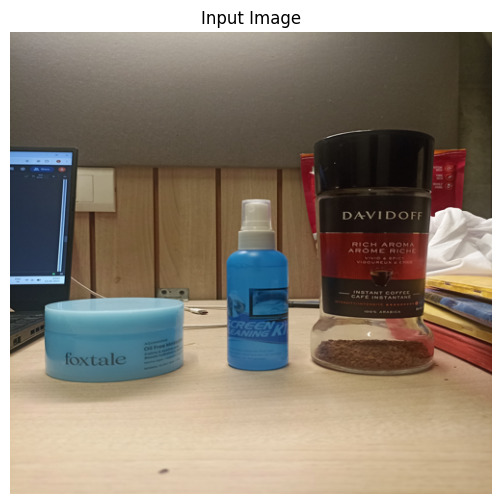

In [34]:
# Load image
image_path = "/content/ex9.jpg"
image = Image.open(image_path).convert("RGB")

image = image.resize((500, 480))

# Display
plt.figure(figsize=(8,6))
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()


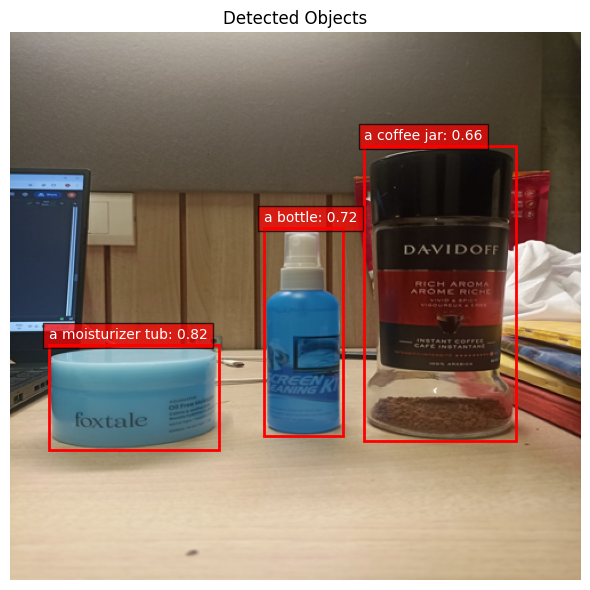

Detected Objects:
1. a moisturizer tub (Score: 0.82)
   Box coordinates: [33.55643844604492, 273.33856201171875, 182.33123779296875, 365.1756286621094]
2. a bottle (Score: 0.72)
   Box coordinates: [221.76063537597656, 171.11648559570312, 291.4726867675781, 353.1510009765625]
3. a coffee jar (Score: 0.66)
   Box coordinates: [310.0413818359375, 98.98614501953125, 442.94232177734375, 357.2573547363281]


In [54]:
# Step 4: Prepare Inputs for Detection
text_prompt = "a bottle. a coffee jar. a moisturizer tub."

# Prepare inputs for detection
inputs = processor(images=image, text=text_prompt, return_tensors="pt").to("cuda")

# Get model predictions
with torch.no_grad():
    outputs = detection_model(**inputs)

# Post-process boxes
target_sizes = torch.tensor([image.size[::-1]]).to("cuda")  # (H, W)
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.30,
    text_threshold=0.45,
    target_sizes=target_sizes
)

# Extract results
boxes = results[0]["boxes"].cpu().numpy()
labels = results[0]["labels"]
scores = results[0]["scores"].cpu().numpy()

# Visualize the detection results
plt.figure(figsize=(8, 6))
plt.imshow(image)

# Draw bounding boxes and labels
for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box.tolist()
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                        fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1-5, f"{label}: {score:.2f}",
            color='white', fontsize=10,
            bbox=dict(facecolor='red', alpha=0.7))

plt.axis('off')
plt.title("Detected Objects")
plt.tight_layout()
plt.show()

# Print detection results
print("Detected Objects:")
for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
    print(f"{i+1}. {label} (Score: {score:.2f})")
    print(f"   Box coordinates: {box.tolist()}")



Number of masks: 3
First mask shape: (480, 500)


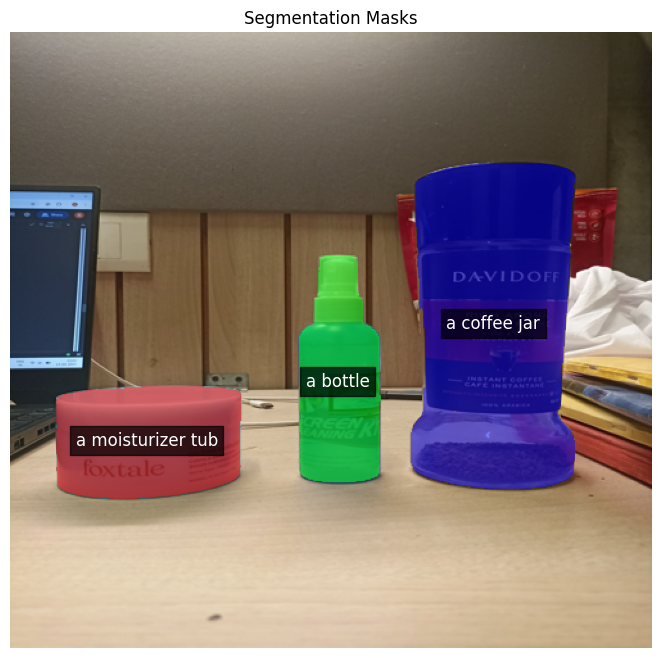

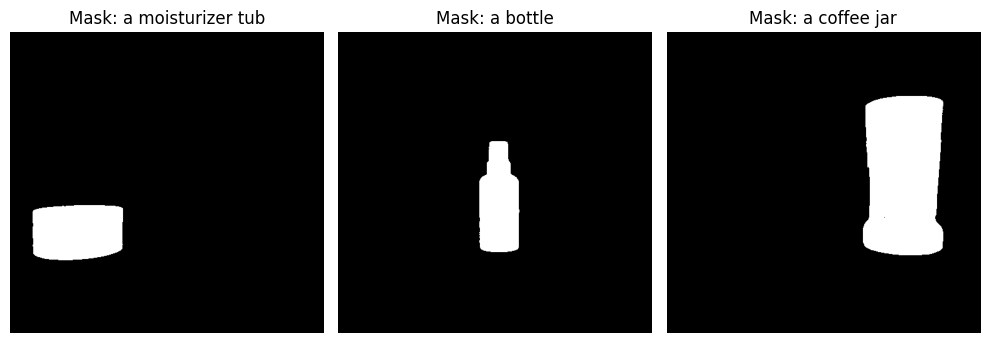

In [55]:
# Convert bounding boxes to SAM format
def boxes_to_sam_format(boxes):
    sam_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = box
        sam_boxes.append([x1, y1, x2, y2])
    return sam_boxes

# Format boxes for SAM
input_boxes = boxes_to_sam_format(boxes)

# Prepare SAM input
sam_inputs = sam_processor(
    image,
    input_boxes=[input_boxes],  # Note the extra list level
    return_tensors="pt"
).to("cuda")

# Run SAM
with torch.no_grad():
    sam_outputs = sam_model(**sam_inputs)

# Post-process masks
masks = sam_processor.image_processor.post_process_masks(
    sam_outputs.pred_masks.cpu(),
    sam_inputs["original_sizes"].cpu(),
    sam_inputs["reshaped_input_sizes"].cpu()
)[0]

# Convert to binary masks (properly handling dimensions)
final_masks = []
for i in range(masks.shape[0]):
    mask = masks[i, 0].numpy() > 0.0  # Take first channel and threshold
    final_masks.append(mask)

# Print shape information for debugging
print(f"Number of masks: {len(final_masks)}")
print(f"First mask shape: {final_masks[0].shape}")

# Visualization with simple overlay technique
plt.figure(figsize=(10, 8))
plt.imshow(np.array(image))

# Create a color map for the masks
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
for i, mask in enumerate(final_masks):
    # Convert mask to RGBA: fully transparent where False, semi-transparent color where True
    color_mask = np.zeros((*mask.shape, 4))

    # Convert color names to RGBA values
    if colors[i % len(colors)] == 'red':
        color_mask[mask] = [1, 0, 0, 0.5]
    elif colors[i % len(colors)] == 'green':
        color_mask[mask] = [0, 1, 0, 0.5]
    elif colors[i % len(colors)] == 'blue':
        color_mask[mask] = [0, 0, 1, 0.5]
    elif colors[i % len(colors)] == 'cyan':
        color_mask[mask] = [0, 1, 1, 0.5]
    elif colors[i % len(colors)] == 'magenta':
        color_mask[mask] = [1, 0, 1, 0.5]
    elif colors[i % len(colors)] == 'yellow':
        color_mask[mask] = [1, 1, 0, 0.5]

    plt.imshow(color_mask)

    # Add label at centroid
    y, x = np.where(mask)
    if len(x) > 0 and len(y) > 0:
        cx, cy = int(np.mean(x)), int(np.mean(y))
        plt.text(cx, cy, labels[i], fontsize=12, color='white',
                bbox=dict(facecolor='black', alpha=0.7),
                ha='center', va='center')

plt.axis('off')
plt.title("Segmentation Masks")
plt.show()

# Show individual masks
plt.figure(figsize=(10, 5))
for i, (mask, label) in enumerate(zip(final_masks, labels)):
    plt.subplot(1, 3, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


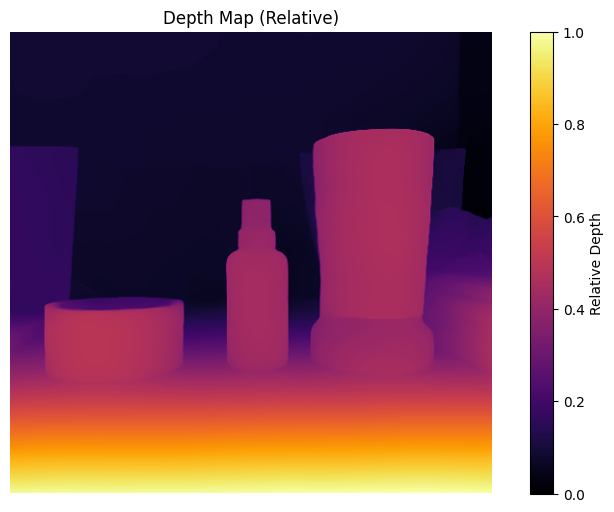

In [43]:
# Prepare the image for depth estimation
depth_inputs = depth_processor(images=image, return_tensors="pt").to("cuda")

# Run the depth model
with torch.no_grad():
    depth_outputs = depth_model(**depth_inputs)
    predicted_depth = depth_outputs.predicted_depth

# Resize the depth map to match your image size
depth_map = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],  # (height, width)
    mode="bicubic",
    align_corners=False
).squeeze().cpu().numpy()

# Normalize depth map for visualization
depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Visualize the depth map
plt.figure(figsize=(10, 6))
plt.imshow(depth_map_normalized, cmap='inferno')
plt.axis('off')
plt.title("Depth Map (Relative)")
plt.colorbar(label='Relative Depth')
plt.show()


In [46]:
# Step 5: Reference Object Calibration

# 1. Identify the reference object (blue spray bottle)
REFERENCE_LABEL = "a bottle"  # Adjust based on your detection labels
ref_idx = labels.index(REFERENCE_LABEL)
ref_mask = final_masks[ref_idx]
ref_box = boxes[ref_idx]

# Known dimensions of the blue spray bottle (in centimeters)
# Adjust these measurements to match your actual spray bottle
REF_REAL_WIDTH = 3.7   # cm - the width of the bottle
REF_REAL_HEIGHT = 13.6  # cm - the height of the bottle

# Calculate pixel dimensions of reference object using the mask
y_ref, x_ref = np.where(ref_mask)
ref_pixel_width = x_ref.max() - x_ref.min()
ref_pixel_height = y_ref.max() - y_ref.min()

# Calculate pixels-per-cm ratio
pixels_per_cm_width = ref_pixel_width / REF_REAL_WIDTH
pixels_per_cm_height = ref_pixel_height / REF_REAL_HEIGHT

# Get depth value at reference object center
ref_center_y, ref_center_x = int(np.mean(y_ref)), int(np.mean(x_ref))
ref_depth = depth_map[ref_center_y, ref_center_x]

# Display reference object info
print(f"Reference Object: {REFERENCE_LABEL}")
print(f"Real dimensions: {REF_REAL_WIDTH}cm × {REF_REAL_HEIGHT}cm")
print(f"Pixel dimensions: {ref_pixel_width}px × {ref_pixel_height}px")
print(f"Conversion ratio: {pixels_per_cm_width:.2f}px/cm (width), {pixels_per_cm_height:.2f}px/cm (height)")
print(f"Reference depth: {ref_depth:.4f}")

Reference Object: a bottle
Real dimensions: 3.7cm × 13.6cm
Pixel dimensions: 63px × 176px
Conversion ratio: 17.03px/cm (width), 12.94px/cm (height)
Reference depth: 3.9115


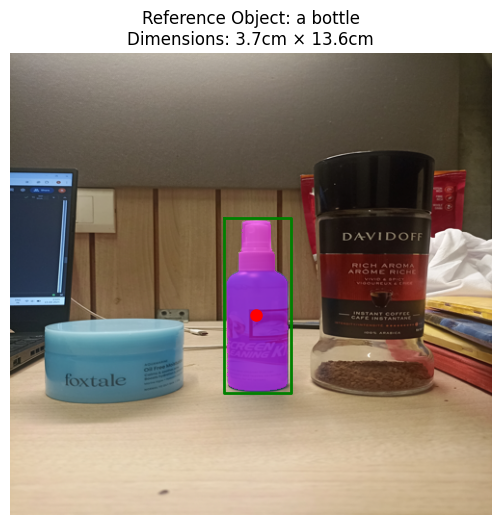

In [47]:
# Visualize the reference object
plt.figure(figsize=(10, 6))
plt.imshow(np.array(image))
plt.imshow(np.ma.masked_where(~ref_mask, ref_mask), alpha=0.5, cmap='spring')
x1, y1, x2, y2 = ref_box.tolist()
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'g-', linewidth=2)
plt.plot(ref_center_x, ref_center_y, 'ro', markersize=8)
plt.title(f"Reference Object: {REFERENCE_LABEL}\nDimensions: {REF_REAL_WIDTH}cm × {REF_REAL_HEIGHT}cm")
plt.axis('off')
plt.show()

In [52]:
# Step 6: Calculate Real-World Dimensions

# Store results
results = []

for i, (mask, label) in enumerate(zip(final_masks, labels)):
    # Skip if this is empty mask
    if not np.any(mask):
        continue

    # Get pixel dimensions
    y_obj, x_obj = np.where(mask)
    pixel_width = x_obj.max() - x_obj.min()
    pixel_height = y_obj.max() - y_obj.min()

    # Get object depth at center
    obj_center_y, obj_center_x = int(np.mean(y_obj)), int(np.mean(x_obj))
    obj_depth = depth_map[obj_center_y, obj_center_x]

    # Scale dimensions based on depth (perspective correction)
    depth_ratio = ref_depth / obj_depth

    # Calculate real dimensions
    real_width = pixel_width / (pixels_per_cm_width * depth_ratio)
    real_height = pixel_height / (pixels_per_cm_height * depth_ratio)

    # Distance from camera (in same units as the reference depth)
    distance = obj_depth * (ref_depth / ref_depth)  # Normalizing to reference

    results.append({
        "object": label,
        "width_cm": round(real_width, 1),
        "height_cm": round(real_height, 1),
        "depth_value": float(obj_depth),
        "distance_cm": round(distance * 10, 1)  # Assuming depth is in meters
    })

In [53]:
# Print results
print("\nObject Measurements:")
print("-" * 60)
print(f"{'Object':<15} {'Width (cm)':<12} {'Height (cm)':<12} {'Distance (cm)':<15}")
print("-" * 60)
for result in results:
    print(f"{result['object']:<15} {result['width_cm']:<12.1f} {result['height_cm']:<12.1f} {result['distance_cm']:<15.1f}")


Object Measurements:
------------------------------------------------------------
Object          Width (cm)   Height (cm)  Distance (cm)  
------------------------------------------------------------
a moisturizer tub 9.3          7.4          43.1           
a bottle        3.7          13.6         39.1           
a coffee jar    7.7          20.1         40.3           


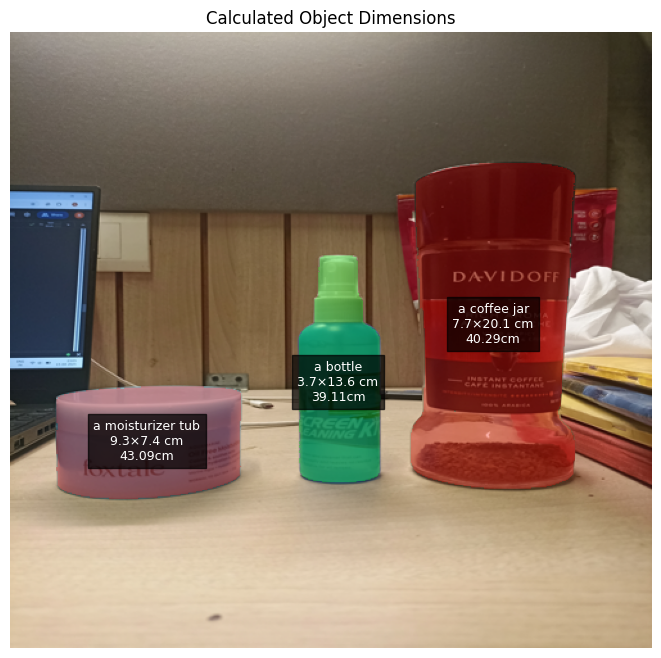

In [51]:
# Visualize all objects with their calculated dimensions
plt.figure(figsize=(12, 8))
plt.imshow(np.array(image))

for i, (mask, result) in enumerate(zip(final_masks, results)):
    # Get object center
    y_obj, x_obj = np.where(mask)
    if len(y_obj) == 0 or len(x_obj) == 0:
        continue

    obj_center_y, obj_center_x = int(np.mean(y_obj)), int(np.mean(x_obj))

    # Color: green for reference, red for others
    color = 'lime' if result['object'] == REFERENCE_LABEL else 'red'

    # Display mask
    plt.imshow(np.ma.masked_where(~mask, mask), alpha=0.3, cmap=plt.cm.colors.ListedColormap([color]))

    # Add dimension text
    plt.text(obj_center_x, obj_center_y,
             f"{result['object']}\n{result['width_cm']}×{result['height_cm']} cm\n{result['distance_cm']/10:.2f}cm",
             color='white', fontsize=9, ha='center', va='center',
             bbox=dict(facecolor='black', alpha=0.7))

plt.title("Calculated Object Dimensions")
plt.axis('off')
plt.show()